**Import Necessary Libraries including pandas, numpy, seaborn, matplotlib, TensorFlow, tensorflow_recommenders, and sklearn.**

In [4]:
pip install -q tensorflow-recommenders

In [5]:
import string # for string manipulation operations
import re # for regular expression operations n.

import pandas as pd #for data manipulation and analysis
import numpy as np #for numerical computing
import seaborn as sns #for data visualization
import matplotlib.pyplot as plt #for data visualization
import tensorflow as tf #for building and training deep learning models
import tensorflow_recommenders as tfrs #as a high-level API for building recommendation models on top of TensorFlow
from collections import Counter #for counting occurrences of elements in a list or other iterable
from typing import Dict, Text #for declaring data types in a function or module
from ast import literal_eval #for evaluating strings as code
from datetime import datetime #for working with dates and times
from sklearn.preprocessing import MinMaxScaler #for feature scaling
from sklearn.feature_extraction.text import TfidfVectorizer #for converting text into numerical features
from sklearn.metrics.pairwise import cosine_similarity #for measuring similarity between two non-zero vectors of an inner product space.
import random #To generate random numbers to select random movies for user to rate
import io

import warnings
warnings.filterwarnings('ignore')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Data and primary cleanup

1. **Data Importation**: Use Pandas library to import three separate datasets: `credits.csv`, `keywords.csv`, and `movies_metadata.csv`. These files are read from a specified path within a Google Drive account that has been mounted to the Google Colab environment.

2. **Data Cleaning - Movies Dataset**:
   - For the `movies_metadata.csv` file, after it's loaded into the `movies` DataFrame,we remove several columns that are deemed unnecessary for the analysis (`'belongs_to_collection'`, `'homepage'`, `'imdb_id'`, `'poster_path'`, `'status'`, `'title'`, `'video'`). This is done via the `drop` method with `axis=1`, which specifies column-wise operation.
   - We further remove rows with indices 19730, 29503, 35587. These rows are removed due to having incorrect data types/ corrupt data that could affect the quality of the dataset.

3. **Type Conversion**:
   - The `id` column in the `movies` DataFrame is explicitly converted to an `int64` data type, which ensures that the IDs are in the correct numerical format for later operations (such as merging).

4. **Data Merging**:
   - The code merges the `movies`, `keywords`, and `credits` DataFrames into a single DataFrame `df` based on the `id` column. This is done using the `merge()` function, which combines datasets on common keys (in this case, the `id` column).

5. **Handling Missing Values**:
   - We fill missing values in `original_language`, `runtime`, and `tagline` columns with empty strings or zero (in case of `runtime`). This step is important to avoid errors related to null values during analysis or model training.

6. **Final Cleanup**:
   - The `df.dropna(inplace=True)` call removes any remaining rows with missing values from the DataFrame in place, meaning that the changes are applied directly to `df` without the need to assign the result to a new variable.

7. **Previewing the Dataset**:
   - `df.head()` verifies that the data has been loaded and formatted as expected.



In [7]:
#Import the required datasets
credits = pd.read_csv('/content/drive/My Drive/datasets/credits.csv')
keywords = pd.read_csv('/content/drive/My Drive/datasets/keywords.csv')
movies = pd.read_csv('/content/drive/My Drive/datasets/movies_metadata.csv').\
                     drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).drop([19730, 29503, 35587])

movies['id'] = movies['id'].astype('int64')
#Merge all the datasets together
df = movies.merge(keywords, on='id').merge(credits, on='id')

#Fill in the missing values
df['original_language'] = df['original_language'].fillna('')
df['runtime'] = df['runtime'].fillna(0)
df['tagline'] = df['tagline'].fillna('')

df.dropna(inplace=True)

#clean dataset
df.head()






,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,cast,crew
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",,7.7,5415.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Roll the dice and unleash the excitement!,6.9,2413.0,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Friends are the people who let you be yourself...,6.1,34.0,"[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Just When His World Is Back To Normal... He's ...,5.7,173.0,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45558 entries, 0 to 46627
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 45558 non-null  object 
 1   budget                45558 non-null  object 
 2   genres                45558 non-null  object 
 3   id                    45558 non-null  int64  
 4   original_language     45558 non-null  object 
 5   original_title        45558 non-null  object 
 6   overview              45558 non-null  object 
 7   popularity            45558 non-null  object 
 8   production_companies  45558 non-null  object 
 9   production_countries  45558 non-null  object 
 10  release_date          45558 non-null  object 
 11  revenue               45558 non-null  float64
 12  runtime               45558 non-null  float64
 13  spoken_languages      45558 non-null  object 
 14  tagline               45558 non-null  object 
 15  vote_average          45

# Extract Meaning Information from columns

- **Purpose**: We want to extract information from columns that contain structured text data, stored as strings of lists of dictionaries.


  - **literal_eval(text)**: Converts the string representation of a list of dictionaries into an actual list of dictionaries.


  - **Columns Application**: The function `get_text` is applied to multiple columns of the DataFrame (`genres`, `production_companies`, `production_countries`, `crew`, `spoken_languages`, `keywords`). This transformation extracts and formats the specific data (like names of genres or companies) into a more readable and usable form.This transformation simplifies the data structure, making it easier to analyze and use in subsequent data processing steps or analytical models.


  - **Custom Object Key**: For the columns `characters` and `actors`, the function is applied with a special argument `obj` to extract different types of information from the same column (`cast`).
    - `characters`: Extracts the value associated with the key `'character'` (likely roles played by the actors).
    - `actors`: Extracts the value associated with the key `'name'` (default, to get actor names).

### More Data Cleanup
- **Removing cast**: The column `cast` is dropped since its data has been extracted into the `characters` and `actors` columns, reducing redundancy.
- **Removing Duplicates**: Rows where the `original_title` is duplicated are removed. This step ensures the uniqueness of entries based on the movie title, which is critical for analyses that require unique entries per movie.
- **Resetting Index**: After dropping rows, the DataFrame's index is reset to ensure it remains continuous and accurate


In [9]:
#A function to extract the useful information from the columns
def get_text(text, obj='name'):
    text = literal_eval(text)

    if len(text) == 1:
        for i in text:
            return i[obj]
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)

#Applying the functions to the columns
df['genres'] = df['genres'].apply(get_text)
df['production_companies'] = df['production_companies'].apply(get_text)
df['production_countries'] = df['production_countries'].apply(get_text)
df['crew'] = df['crew'].apply(get_text)
df['spoken_languages'] = df['spoken_languages'].apply(get_text)
df['keywords'] = df['keywords'].apply(get_text)

#Create new columns
df['characters'] = df['cast'].apply(get_text, obj='character')
df['actors'] = df['cast'].apply(get_text)

df.drop('cast', axis=1, inplace=True)
df = df[~df['original_title'].duplicated()]
df = df.reset_index(drop=True)

In [10]:
#Information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42373 entries, 0 to 42372
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 42373 non-null  object 
 1   budget                42373 non-null  object 
 2   genres                42373 non-null  object 
 3   id                    42373 non-null  int64  
 4   original_language     42373 non-null  object 
 5   original_title        42373 non-null  object 
 6   overview              42373 non-null  object 
 7   popularity            42373 non-null  object 
 8   production_companies  42373 non-null  object 
 9   production_countries  42373 non-null  object 
 10  release_date          42373 non-null  object 
 11  revenue               42373 non-null  float64
 12  runtime               42373 non-null  float64
 13  spoken_languages      42373 non-null  object 
 14  tagline               42373 non-null  object 
 15  vote_average       

In [11]:
#Changing the datatype of certain columns
df['release_date'] = pd.to_datetime(df['release_date'])
df['budget'] = df['budget'].astype('float64')
df['popularity'] = df['popularity'].astype('float64')

In [12]:
df.head()

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,...,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,crew,characters,actors
0,False,30000000.0,"Animation, Comedy, Family",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,...,373554033.0,81.0,English,,7.7,5415.0,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,..."
1,False,65000000.0,"Adventure, Fantasy, Family",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,...,262797249.0,104.0,"English, Français",Roll the dice and unleash the excitement!,6.9,2413.0,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ..."
2,False,0.0,"Romance, Comedy",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,"Warner Bros., Lancaster Gate",United States of America,...,0.0,101.0,English,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph..."
3,False,16000000.0,"Comedy, Drama, Romance",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,United States of America,...,81452156.0,127.0,English,Friends are the people who let you be yourself...,6.1,34.0,"based on novel, interracial relationship, sing...","Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ...","Whitney Houston, Angela Bassett, Loretta Devin..."
4,False,0.0,Comedy,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"Sandollar Productions, Touchstone Pictures",United States of America,...,76578911.0,106.0,English,Just When His World Is Back To Normal... He's ...,5.7,173.0,"baby, midlife crisis, confidence, aging, daugh...","Alan Silvestri, Elliot Davis, Nancy Meyers, Na...","George Banks, Nina Banks, Franck Eggelhoffer, ...","Steve Martin, Diane Keaton, Martin Short, Kimb..."


## Import ratings.csv dataset and perform cleanup and merging

This code block performs several operations related to loading and processing a dataset of movie ratings. Here's a step-by-step breakdown of what each line in the code is doing:

- Importing the Ratings Dataset
- Converting Timestamps to Date, deleting previous timestamp column
  - After converting the timestamps to a more readable date format and storing this information in the date column, the original timestamp column is no longer needed and is therefore removed from the DataFrame.
- Merging with columns from previous merged dataset (df)
- Removing Rows with Missing Movie IDs
  
   - Filters out any rows in `ratings_df` that have a missing (NaN) `id` value post-merge. This step is crucial to ensure that the dataset does not contain entries without corresponding movie details.

- Dropping the Redundant ID Column
   
   - After ensuring all entries have valid movie details, the `id` column (which was used for merging) is dropped as it is no longer needed.

- Resetting the DataFrame Index
   - After all the previous deletions and filtering, the index of the DataFrame might be unordered or have gaps. This line resets the index to make it sequential again, starting from 0, which helps in maintaining DataFrame integrity and can improve the performance of subsequent operations.

In [13]:
ratings_df = pd.read_csv('/content/drive/My Drive/datasets/ratings_small.csv')

ratings_df['date'] = ratings_df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
ratings_df.drop('timestamp', axis=1, inplace=True)

ratings_df = ratings_df.merge(df[['id', 'original_title', 'genres', 'overview']], left_on='movieId',right_on='id', how='left')
ratings_df = ratings_df[~ratings_df['id'].isna()]
ratings_df.drop('id', axis=1, inplace=True)
ratings_df.reset_index(drop=True, inplace=True)

ratings_df.head()

,userId,movieId,rating,date,original_title,genres,overview
0,1,1371,2.5,2009-12-14 02:52:15,Rocky III,Drama,"Now the world champion, Rocky Balboa is living..."
1,1,1405,1.0,2009-12-14 02:53:23,Greed,"Drama, History",Greed is the classic 1924 silent film by Erich...
2,1,2105,4.0,2009-12-14 02:52:19,American Pie,"Comedy, Romance","At a high-school party, four friends find that..."
3,1,2193,2.0,2009-12-14 02:53:18,My Tutor,"Comedy, Drama, Romance",High school senior Bobby Chrystal fails his Fr...
4,1,2294,2.0,2009-12-14 02:51:48,Jay and Silent Bob Strike Back,Comedy,When Jay and Silent Bob learn that their comic...


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42373 entries, 0 to 42372
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   adult                 42373 non-null  object        
 1   budget                42373 non-null  float64       
 2   genres                42373 non-null  object        
 3   id                    42373 non-null  int64         
 4   original_language     42373 non-null  object        
 5   original_title        42373 non-null  object        
 6   overview              42373 non-null  object        
 7   popularity            42373 non-null  float64       
 8   production_companies  42373 non-null  object        
 9   production_countries  42373 non-null  object        
 10  release_date          42373 non-null  datetime64[ns]
 11  revenue               42373 non-null  float64       
 12  runtime               42373 non-null  float64       
 13  spoken_languages

In [15]:
ratings_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43188 entries, 0 to 43187
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   userId          43188 non-null  int64         
 1   movieId         43188 non-null  int64         
 2   rating          43188 non-null  float64       
 3   date            43188 non-null  datetime64[ns]
 4   original_title  43188 non-null  object        
 5   genres          43188 non-null  object        
 6   overview        43188 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 2.3+ MB


# **Data Visualizations**

### I want to perform some visualizations and it can be useful for the following reasons:

**Understanding the Data:** Visualization helps to quickly understand and explore the data. It reveals patterns, trends, and correlations that might not be evident in raw data, which can be especially valuable when deciding how to manipulate data during preprocessing.

**Feature Relationships:** By visualizing the relationships between different features, we can gain insights into the relevance of certain variables and how they interact with each other. This can be crucial when designing the architecture of my model, such as deciding which features to include or combine.

**Inspiring Model Design:** Sometimes, seeing the data in a visual format can inspire specific approaches to machine learning model design, such as choosing between different types of neural network layers or how to configure them.

#### **Distribution of Movie Ratings: Shows how users generally rate movies, which can help in understanding the central tendency and dispersion of ratings.**

What we can deduce from the visualization:

1. Skewness: The distribution is left-skewed, meaning that there are more high ratings than low ratings. Most movies seem to receive ratings of 3.5 and above, with the frequency decreasing as the rating value decreases.

2. Rating Preference: Users tend to rate movies positively. This could be indicative of a tendency to rate movies they like and not rate those they dislike, or it could mean that most of the movies in the dataset are of relatively high quality according to the user base.

3. Data Density: There’s a dense concentration of ratings between 3.5 and 4.5. These ratings are more common than the extremes, suggesting that users are more often moderately satisfied with the movies they watch.

4. Implications for Recommendation Systems: For a recommendation system, this skew could imply that it might be challenging to distinguish between highly-rated movies since there are many of them; therefore, other features might be necessary to improve the recommendations, such as user-specific or content-based information.

5. Data Transformation Considerations: The skewness might necessitate data transformation if algorithms sensitive to non-normal distributions are used, as many machine learning models work better with normally distributed data.

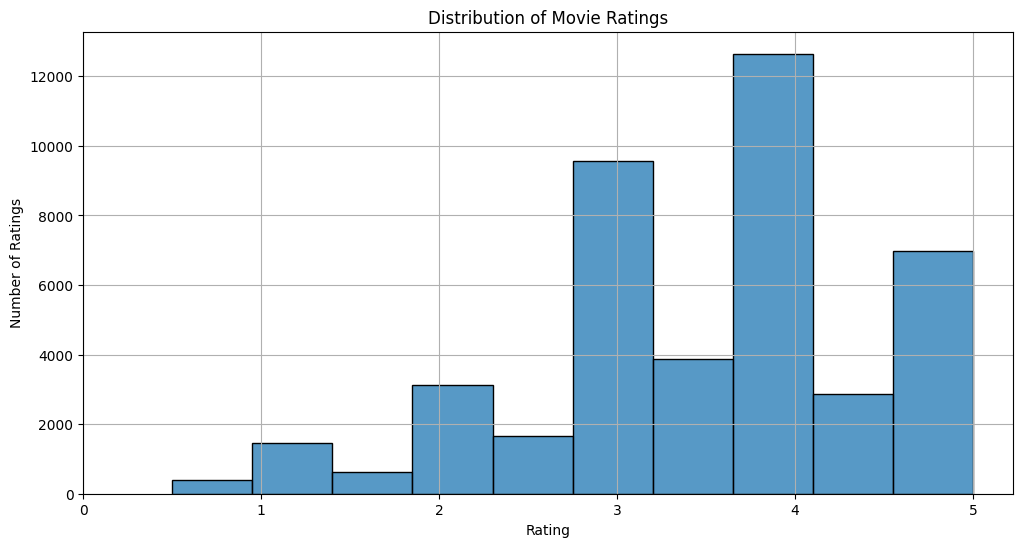

In [16]:
# Plotting the distribution of movie ratings
plt.figure(figsize=(12, 6))  # Set the figure size for better readability
sns.histplot(ratings_df['rating'], bins=10, kde=False)  # 10 bins should be enough to show the distribution of ratings from 0.5 to 5.0
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.xticks(range(0, 6))
plt.grid(True)  # Adding a grid for visual aid
plt.show()  # Displaying the plot


#### **Genre Popularity: Displaying the percentage of movies per genre could help in understanding user preferences and genre popularity**
What we can deduce from the visualization:

1) Drama is the most dominant genre with over 18000 movies

2) Out of 5 top genres, there are still many genres in the dataset. They hold 38.67% of total genres in the movies

(-1.25, 1.25, -1.25, 1.25)

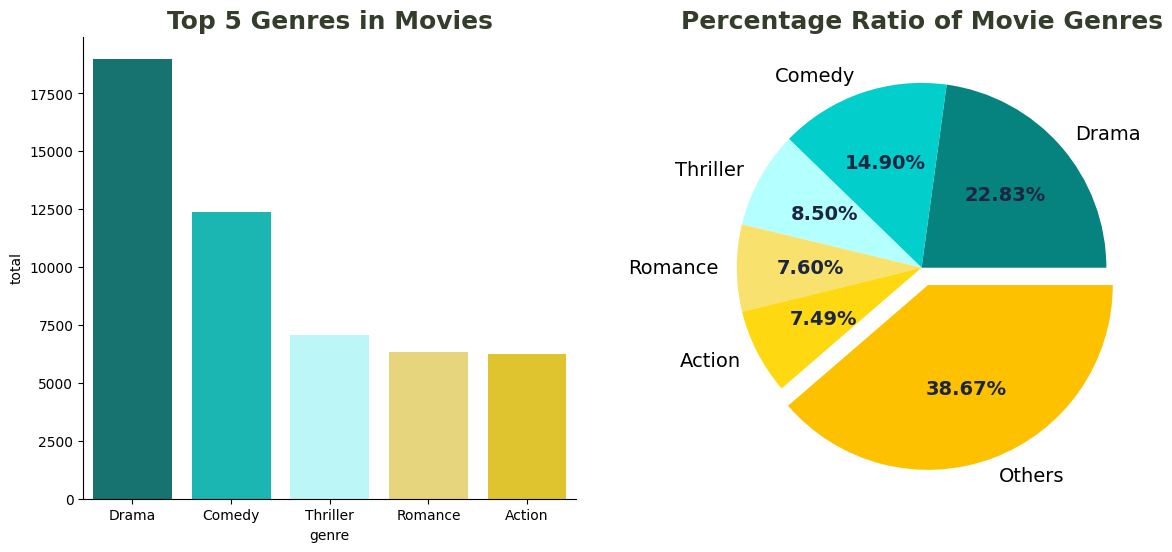

In [17]:
genres_list = []
for i in df['genres']:
    genres_list.extend(i.split(', '))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
ax = sns.barplot(data=df_plot, x='genre', y='total', ax=axes[0], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])
ax.set_title('Top 5 Genres in Movies', fontsize=18, weight=600, color='#333d29')
sns.despine()

df_plot_full = pd.DataFrame([Counter(genres_list)]).transpose().sort_values(by=0, ascending=False)
df_plot.loc[len(df_plot)] = {'genre': 'Others', 'total':df_plot_full[6:].sum()[0]}
plt.title('Percentage Ratio of Movie Genres', fontsize=18, weight=600, color='#333d29')
wedges, texts, autotexts = axes[1].pie(x=df_plot['total'], labels=df_plot['genre'], autopct='%.2f%%',
                                       textprops=dict(fontsize=14), explode=[0,0,0,0,0,0.1], colors=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])

for autotext in autotexts:
    autotext.set_color('#1c2541')
    autotext.set_weight('bold')

axes[1].axis('off')

#### **The Relationship Between Rating and Popularity**

What we can deduce from the visualization:

1)Movies that either got rating 0 or 10 are basically caused by small number of voter. As the vote count increase, the rating is most likely around 5 to 8.5

2)It's clear that popular movies will get more vote count as shown from above plot


In [18]:
# #Here, I am choosing movies released after 2009 and which were originally shot in English
# df = df[df['release_date'].dt.year>2009]
# df = df[df['original_language']=='en']
# df = df.reset_index()



Text(0.5, 1.0, 'The Relationship Between Rating and Popularity')

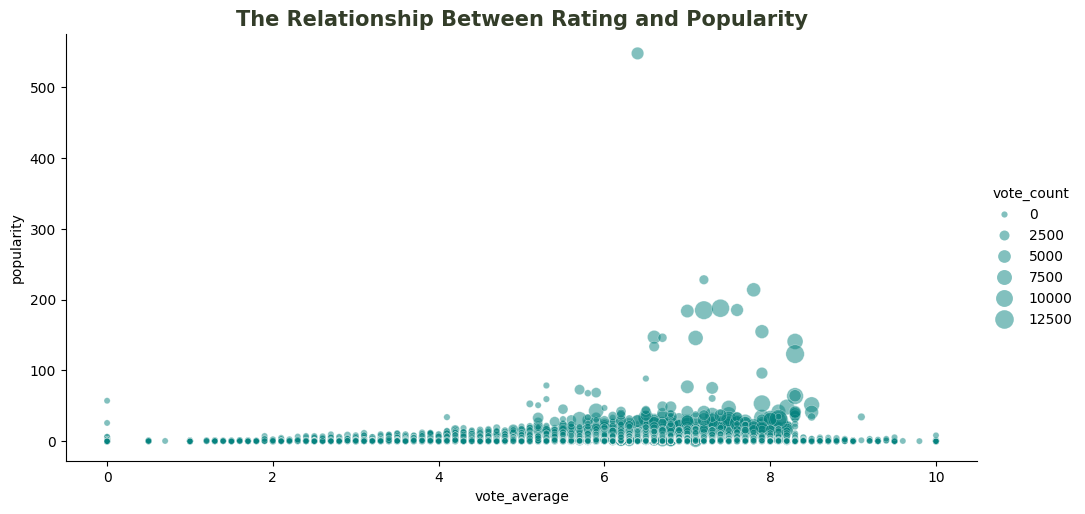

In [19]:
sns.relplot(data=df, x='vote_average', y='popularity', size='vote_count',
            sizes=(20, 200), alpha=.5, aspect=2, color='#06837f')
plt.title('The Relationship Between Rating and Popularity', fontsize=15, weight=600, color='#333d29')

#### **Top 5 of Movie features**

What we can deduce from the visualisation:

1)For this particular dataset, english is on top of the list for the original and spoken language in the movies

2)Jr. and Cedric Gibbons are actor and crew involved in the most movies in the list respectively

3)Warner Bros. with 1194 movies make it become top 1 production company in the list

4)Many great production companies come from USA. So, it's not a surprise if USA is become our top 1 for production country

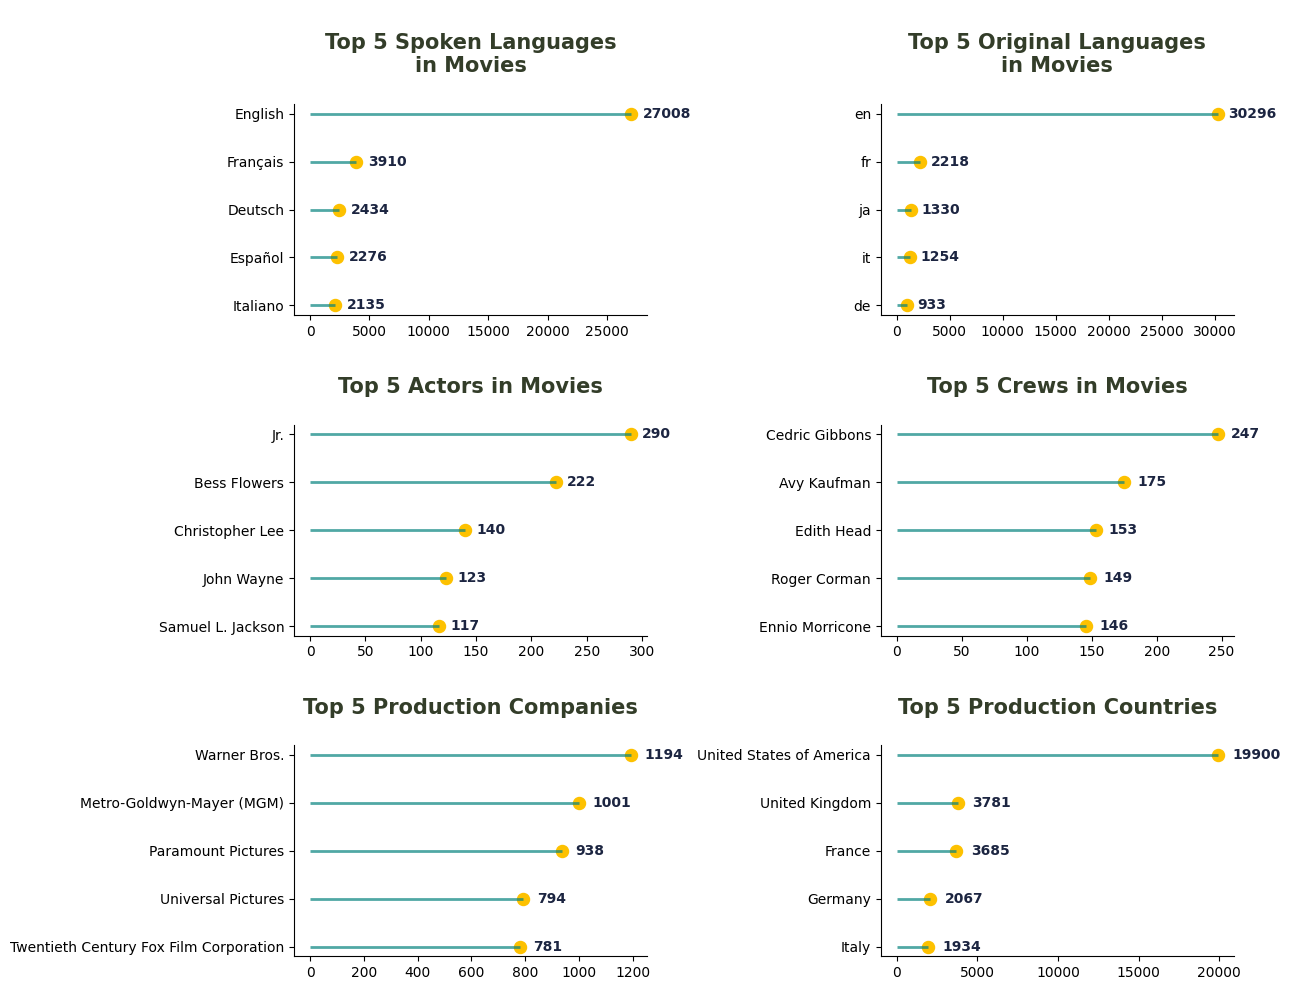

In [20]:
original_language_list = []
for i in df['original_language']:
    original_language_list.extend(i.split(', '))

spoken_languages_list = []
for i in df['spoken_languages']:
    if i != '':
        spoken_languages_list.extend(i.split(', '))

actors_list = []
for i in df['actors']:
    if i != '':
        actors_list.extend(i.split(', '))

crew_list = []
for i in df['crew']:
    if i != '':
        crew_list.extend(i.split(', '))

company_list = []
for i in df['production_companies']:
    if i != '':
        company_list.extend(i.split(', '))

country_list = []
for i in df['production_countries']:
    if i != '':
        country_list.extend(i.split(', '))

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(13, 10))

# Spoken language plot
df_plot1 = pd.DataFrame(Counter(spoken_languages_list).most_common(5), columns=['language', 'total']).sort_values(by='total', ascending=True)
axes[0,0].hlines(y=df_plot1['language'], xmin=0, xmax=df_plot1['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[0,0].scatter(x=df_plot1['total'], y=df_plot1['language'], s = 75, color='#fdc100')
axes[0,0].set_title('\nTop 5 Spoken Languages\nin Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot1['total']):
    axes[0,0].text(value+1000, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Original Language plot
df_plot2 = pd.DataFrame(Counter(original_language_list).most_common(5), columns=['language', 'total']).sort_values(by='total', ascending=True)
axes[0,1].hlines(y=df_plot2['language'], xmin=0, xmax=df_plot2['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[0,1].scatter(x=df_plot2['total'], y=df_plot2['language'], s = 75, color='#fdc100')
axes[0,1].set_title('\nTop 5 Original Languages\nin Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot2['total']):
    axes[0,1].text(value+1000, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Actor plot
df_plot3 = pd.DataFrame(Counter(actors_list).most_common(5), columns=['actor', 'total']).sort_values(by='total', ascending=True)
axes[1,0].hlines(y=df_plot3['actor'], xmin=0, xmax=df_plot3['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[1,0].scatter(x=df_plot3['total'], y=df_plot3['actor'], s = 75, color='#fdc100')
axes[1,0].set_title('\nTop 5 Actors in Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot3['total']):
    axes[1,0].text(value+10, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Crew plot
df_plot4 = pd.DataFrame(Counter(crew_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[1,1].hlines(y=df_plot4['name'], xmin=0, xmax=df_plot4['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[1,1].scatter(x=df_plot4['total'], y=df_plot4['name'], s = 75, color='#fdc100')
axes[1,1].set_title('\nTop 5 Crews in Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot4['total']):
    axes[1,1].text(value+10, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Company plot
df_plot5 = pd.DataFrame(Counter(company_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[2,0].hlines(y=df_plot5['name'], xmin=0, xmax=df_plot5['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[2,0].scatter(x=df_plot5['total'], y=df_plot5['name'], s = 75, color='#fdc100')
axes[2,0].set_title('\nTop 5 Production Companies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot5['total']):
    axes[2,0].text(value+50, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Country plot
df_plot6 = pd.DataFrame(Counter(country_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[2,1].hlines(y=df_plot6['name'], xmin=0, xmax=df_plot6['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[2,1].scatter(x=df_plot6['total'], y=df_plot6['name'], s = 75, color='#fdc100')
axes[2,1].set_title('\nTop 5 Production Countries\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot6['total']):
    axes[2,1].text(value+900, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

sns.despine()
plt.tight_layout()


# Content Based Recommendation System


#### The first method we are using to build a recommendation system is content based. We calculate a weighted rating for movies that uses both the average votes a movie receives (`vote_average`) and the number of votes (`vote_count`) to create a score that considers both popularity and critical acclaim. This method is commonly used to prevent movies with very few high votes from ranking too highly.

Here’s a breakdown of the variables and calculations:

1. `R`: the average rating for each movie (`vote_average`).
2. `v`: the number of votes for each movie (`vote_count`).
3. `m`: the minimum votes required to be listed in the chart. Set to the 80th percentile of the `vote_count`, which means only movies with more votes than at least 80% of the movies in the dataset will be considered.
4. `C`: the mean vote across the whole report (`vote_average.mean()`).

The weighted average is calculated by this formula:
<b>W</b> = (<b>R</b> &middot; <b>v</b> + <b>C</b> &middot; <b>m</b>) / (<b>v</b> + <b>m</b>)

where:

  - <b>W</b> = weighted rating
  - <b>R</b> = average for the movie as a number from 1 to 10 (mean) = (Rating)
  - <b>v</b> = number of votes for the movie = (votes)
  - <b>m</b> = minimum votes required to be listed in the Top 250 (currently 25,000)
  - <b>C</b> = the mean vote across the whole report (currently 7.0)


The part `R*v` gives more weight to movies with more votes.

The part `C*m` adds a baseline score based on the average rating.

The denominator `v+m` normalizes the score.

After computing the weighted average, the code scales both `popularity` and `weighted_average` features between 0 and 1 using `MinMaxScaler`. This ensures that both features contribute equally to the final score since they are now on the same scale.

Then, the DataFrame `weighted_df` is created with these scaled values, and an index is set to the movie titles (`original_title`).

The final score is computed as a weighted sum of `weighted_average` (with a weight of 0.4) and `popularity` (with a weight of 0.6). This score aims to balance a movie's popularity with its critical acclaim.

Finally, the movies are sorted by their score in descending order, and the top 10 movies are displayed.

The output shows the top 10 movies with their respective `popularity`, `weighted_average`, and the calculated `score`. The `original_title` serves as the index of the DataFrame. For example, "Minions" has a `popularity` score of 1.0 (the highest among the top 10 after scaling) and a `weighted_average` of approximately 0.60, resulting in a final `score` of 0.840453. "Whiplash", despite having the highest `weighted_average` of 1.0, has a lower `popularity` score, which results in a final `score` of 0.470465. The mix of these two factors is what places these movies at their respective ranks in the list.

In [21]:

R = df['vote_average']
v = df['vote_count']
# We will only consider movies that have more votes than at least 80% of the movies in our dataset
m = df['vote_count'].quantile(0.8)
C = df['vote_average'].mean()

df['weighted_average'] = (R*v + C*m)/(v+m)

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['popularity', 'weighted_average']])
weighted_df = pd.DataFrame(scaled, columns=['popularity', 'weighted_average'])

weighted_df.index = df['original_title']

People watch a movie not just because they see a good rating for that movie, but also because of the hype of certain movie. So, in this case, put popularity into a consideration is a wise choice

Let's take **40% **weight for weigthed average and **60%** weight for popularity considering people don't want to miss a hype movie even the reviews and ratings are poor. Next, we create a new column called score which stores the result

In [22]:
weighted_df['score'] = weighted_df['weighted_average']*0.4 + weighted_df['popularity'].astype('float64')*0.6

In [23]:
weighted_df_sorted = weighted_df.sort_values(by='score', ascending=False)
weighted_df_sorted.head(10)

,popularity,weighted_average,score
original_title,,,
Minions,1.000000,0.603532,0.841413
Big Hero 6,0.390602,0.827561,0.565386
Baby Driver,0.416507,0.727736,0.540998
Guardians of the Galaxy Vol. 2,0.338511,0.794867,0.521054
Pulp Fiction,0.257449,0.908395,0.517827
Deadpool,0.343132,0.764657,0.511742
Gone Girl,0.282748,0.843413,0.507014
The Dark Knight,0.224968,0.909123,0.498630
Avatar,0.338036,0.732643,0.495879


#### We already got the first result of our recommender system, and now we will combine those score with the similarity score




In [24]:
df.info()
content_df = df[['original_title', 'adult', 'genres', 'overview', 'production_companies', 'tagline', 'keywords', 'crew', 'characters', 'actors']]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42373 entries, 0 to 42372
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   adult                 42373 non-null  object        
 1   budget                42373 non-null  float64       
 2   genres                42373 non-null  object        
 3   id                    42373 non-null  int64         
 4   original_language     42373 non-null  object        
 5   original_title        42373 non-null  object        
 6   overview              42373 non-null  object        
 7   popularity            42373 non-null  float64       
 8   production_companies  42373 non-null  object        
 9   production_countries  42373 non-null  object        
 10  release_date          42373 non-null  datetime64[ns]
 11  revenue               42373 non-null  float64       
 12  runtime               42373 non-null  float64       
 13  spoken_languages

In [25]:
def separate(text):
    clean_text = []
    for t in text.split(','):
        cleaned = re.sub('\(.*\)', '', t) # Remove text inside parentheses
        cleaned = cleaned.translate(str.maketrans('','', string.digits))
        cleaned = cleaned.replace(' ', '')
        cleaned = cleaned.translate(str.maketrans('','', string.punctuation)).lower()
        clean_text.append(cleaned)
    return ' '.join(clean_text)

def remove_punc(text):
    cleaned = text.translate(str.maketrans('','', string.punctuation)).lower()
    clean_text = cleaned.translate(str.maketrans('','', string.digits))
    return clean_text

In [26]:
content_df.head()


,original_title,adult,genres,overview,production_companies,tagline,keywords,crew,characters,actors
0,Toy Story,False,"Animation, Comedy, Family","Led by Woody, Andy's toys live happily in his ...",Pixar Animation Studios,,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,..."
1,Jumanji,False,"Adventure, Fantasy, Family",When siblings Judy and Peter discover an encha...,"TriStar Pictures, Teitler Film, Interscope Com...",Roll the dice and unleash the excitement!,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ..."
2,Grumpier Old Men,False,"Romance, Comedy",A family wedding reignites the ancient feud be...,"Warner Bros., Lancaster Gate",Still Yelling. Still Fighting. Still Ready for...,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph..."
3,Waiting to Exhale,False,"Comedy, Drama, Romance","Cheated on, mistreated and stepped on, the wom...",Twentieth Century Fox Film Corporation,Friends are the people who let you be yourself...,"based on novel, interracial relationship, sing...","Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ...","Whitney Houston, Angela Bassett, Loretta Devin..."
4,Father of the Bride Part II,False,Comedy,Just when George Banks has recovered from his ...,"Sandollar Productions, Touchstone Pictures",Just When His World Is Back To Normal... He's ...,"baby, midlife crisis, confidence, aging, daugh...","Alan Silvestri, Elliot Davis, Nancy Meyers, Na...","George Banks, Nina Banks, Franck Eggelhoffer, ...","Steve Martin, Diane Keaton, Martin Short, Kimb..."


In [ ]:
content_df.info()

In [27]:
content_df['adult'] = content_df['adult'].apply(remove_punc)
content_df['genres'] = content_df['genres'].apply(remove_punc)
content_df['overview'] = content_df['overview'].apply(remove_punc)
content_df['production_companies'] = content_df['production_companies'].apply(separate)
content_df['tagline'] = content_df['tagline'].apply(remove_punc)
content_df['keywords'] = content_df['keywords'].apply(separate)
content_df['crew'] = content_df['crew'].apply(separate)
content_df['characters'] = content_df['characters'].apply(separate)
content_df['actors'] = content_df['actors'].apply(separate)

content_df['bag_of_words'] = ''
content_df['bag_of_words'] = content_df[content_df.columns[1:]].apply(lambda x: ' '.join(x), axis=1)
content_df.set_index('original_title', inplace=True)

content_df = content_df[['bag_of_words']]
content_df.head()

,bag_of_words
original_title,
Toy Story,false animation comedy family led by woody and...
Jumanji,false adventure fantasy family when siblings j...
Grumpier Old Men,false romance comedy a family wedding reignite...
Waiting to Exhale,false comedy drama romance cheated on mistreat...
Father of the Bride Part II,false comedy just when george banks has recove...


A common method to find similarity between 2 movies is a method called cosine similarity. There are of course a bunch of methods that you can try such as euclidean and sigmoidto know which one performs best

However, calculate similarity for all the movies require an expensive resources. So, we only take the first 10000 movies from weighted_df_sorted

In [28]:
content_df = weighted_df_sorted[:10000].merge(content_df, left_index=True, right_index=True, how='left')

tfidf = TfidfVectorizer(stop_words='english', min_df=5)
tfidf_matrix = tfidf.fit_transform(content_df['bag_of_words'])
tfidf_matrix.shape

(10000, 28645)

In [29]:
cos_sim = cosine_similarity(tfidf_matrix)
cos_sim.shape

(10000, 10000)

In [30]:
content_df.head()

,popularity,weighted_average,score,bag_of_words
original_title,,,,
Minions,1.000000,0.603532,0.841413,false family animation adventure comedy minion...
Big Hero 6,0.390602,0.827561,0.565386,false adventure family animation action comedy...
Baby Driver,0.416507,0.727736,0.540998,false action crime after being coerced into wo...
Guardians of the Galaxy Vol. 2,0.338511,0.794867,0.521054,false action adventure comedy science fiction ...
Pulp Fiction,0.257449,0.908395,0.517827,false thriller crime a burgerloving hit man hi...


In [31]:
def predict(title, similarity_weight=0.7, top_n=10):
    data = content_df.reset_index()
    index_movie = data[data['original_title'] == title].index
    similarity = cos_sim[index_movie].T

    sim_df = pd.DataFrame(similarity, columns=['similarity'])
    final_df = pd.concat([data, sim_df], axis=1)
    # You can also play around with the number
    final_df['final_score'] = final_df['score']*(1-similarity_weight) + final_df['similarity']*similarity_weight

    final_df_sorted = final_df.sort_values(by='final_score', ascending=False).head(top_n)
    final_df_sorted.set_index('original_title', inplace=True)
    return final_df_sorted[['score', 'similarity', 'final_score']]


In [32]:
predict('Toy Story', similarity_weight=0.7, top_n=10)

,score,similarity,final_score
original_title,,,
Toy Story,0.348515,1.000000,0.804555
Toy Story 2,0.317785,0.537320,0.471460
Toy Story 3,0.336500,0.274778,0.293295
Toy Story of Terror!,0.282269,0.294860,0.291082
Small Fry,0.256223,0.271028,0.266586
Hawaiian Vacation,0.266277,0.263819,0.264556
Minions,0.841413,0.005376,0.256187
Finding Nemo,0.346185,0.203631,0.246397
WALL·E,0.348682,0.196733,0.242317


## Prediction Model and hyperparameters

**Machine Learning Model and Structure:**
The machine learning model in the code is a content-based filtering system rather than a traditional predictive model like regression or classification. It does not predict a continuous value or classify input into categories but instead recommends items based on similarity scores. The structure of the model is built upon the calculation of a "bag of words" from textual data and applying TF-IDF vectorization to this data. Cosine similarity is then used to measure how similar the movies are to each other based on their content.  It relies on a matrix operation that calculates the cosine similarity between vectors representing movies.


**Model Parameters and Predictions:**
In this content-based recommender system, the "parameters" could be considered as the features extracted from the TF-IDF vectorization process and the cosine similarity scores. Once the TF-IDF matrix is created, the system does not explicitly learn from data in the same way that a neural network or regression model does; thus, it does not have model parameters in the traditional sense.

**Hyperparameters in the code:**

min_df in the TfidfVectorizer - This is set to 5, meaning that terms appearing in fewer than 5 documents will be discarded.

similarity_weight in the predict() function - This is used to weight the importance of the content-based similarity relative to other scoring metrics; in the provided code, it defaults to 0.7.





## Model Evaluation


**Model Evaluation for Content-Based Recommender Systems:**
Content-based recommender systems, such as the one described in the code, are typically evaluated using different metrics compared to predictive models. Because these systems don't make traditional predictions (like a regression or classification model does), standard metrics like accuracy or RMSE are not directly applicable. Instead, we focus on the relevance and quality of the recommendations provided to the user.



Evaluation metrics that could be used include:

1. **Precision@k**: This measures the proportion of recommended items in the top-k set that are relevant.
2. **Recall@k**: This measures the proportion of relevant items found in the top-k recommendations.
3. **F1 score@k**: The harmonic mean of precision and recall, giving a single score that balances both.
4. **Mean Average Precision (MAP)**: This accounts for the order of recommendations by averaging the precision scores after each relevant item is retrieved.
5. **Normalized Discounted Cumulative Gain (nDCG)**: This metric also considers the order of recommendations, giving more weight to relevant items that appear earlier in the recommendation list.


In practice, the evaluation of a recommender system is often subjective and can benefit greatly from user studies and A/B testing to determine the actual user satisfaction with the recommendations.


# Hybrid NN Movie Recommendation System using Collaborative filtering and matrix factorization

Tensorflow comes with a library called TensorFlow Recommenders (TFRS) for building a recommender system. It's built on Keras and aims to have a gentle learning curve while still giving you the flexibility to build complex models.

This time, we use multi-objective approach that applies both implicit (movie watches) and explicit signals (ratings). In the end, we can predict what movies should the user watch along with the given rating corresponds to historical data

In [33]:
#Selecting the id and title column of the merged dataframe
movies_df = df[['id', 'original_title']]
movies_df.rename(columns={'id':'movieId'}, inplace=True)
movies_df.head()

,movieId,original_title
0,862,Toy Story
1,8844,Jumanji
2,15602,Grumpier Old Men
3,31357,Waiting to Exhale
4,11862,Father of the Bride Part II


In [34]:
#Selecting the UserId, title, and rating from the ratings dataframe
# ratings_df = ratings_df[['userId', 'original_title', 'rating']]
# ratings_df.head()

In [35]:
#Resetting the index of the movies dataframe
# movies_df = movies_df.reset_index()
# movies_df.head()

In [36]:
# #Resetting the index of the merged dataframe
# df = df.reset_index()

# df = df.drop('level_0', axis=1)
# df.head()
# # df.drop('level_0')

In [37]:
# #Sorting by popularity to let the user rate the most popular ones
# pdf = df.sort_values('popularity', ascending=False)
# pdf = pdf.reset_index()
# pdf.head()

In [38]:
#Changing the datatype to string
ratings_df['userId'] = ratings_df['userId'].astype(str)

#Creating data for the model
ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df[['userId', 'original_title', 'rating']]))
movies = tf.data.Dataset.from_tensor_slices(dict(movies_df[['original_title']]))

ratings = ratings.map(lambda x: {
    "original_title": x["original_title"],
    "userId": x["userId"],
    "rating": float(x["rating"])
})

movies = movies.map(lambda x: x["original_title"])

In [39]:
#Displaying the total data
print('Total Data: {}'.format(len(ratings)))

tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = ratings.take(35_000)
test = ratings.skip(35_000).take(8_188)

Total Data: 43188


In [40]:
movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000).map(lambda x: x["userId"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

print('Unique Movies: {}'.format(len(unique_movie_titles)))
print('Unique users: {}'.format(len(unique_user_ids)))

Unique Movies: 42373
Unique users: 671


In [41]:
#Creating the TensorFlow Model
class MovieModel(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    # We take the loss weights in the constructor: this allows us to instantiate
    # several model objects with different loss weights.

    super().__init__()

    embedding_dimension = 64

    # User and movie models.
    self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # A small model to take in user and movie embeddings and predict ratings.
    # We can make this as complicated as we want as long as we output a scalar
    # as our prediction.
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # The tasks.
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.movie_model)
        )
    )

    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["userId"])
    # And pick out the movie features and pass them into the movie model.
    movie_embeddings = self.movie_model(features["original_title"])

    return (
        user_embeddings,
        movie_embeddings,
        # We apply the multi-layered rating model to a concatentation of
        # user and movie embeddings.
        self.rating_model(
            tf.concat([user_embeddings, movie_embeddings], axis=1)
        ),
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("rating")

    user_embeddings, movie_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(labels=ratings,predictions=rating_predictions)
    retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss + self.retrieval_weight * retrieval_loss)

In [ ]:
#Creating a model based on the above Class defintion

model = MovieModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

cached_train = train.shuffle(100_000).batch(1_000).cache()
cached_test = test.batch(1_000).cache()

history = model.fit(cached_train, epochs=10, validation_data=cached_test)



Epoch 1/10
35/35 [==============================] - 232s 7s/step - root_mean_squared_error: 1.5184 - factorized_top_k/top_1_categorical_accuracy: 2.5714e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0077 - factorized_top_k/top_10_categorical_accuracy: 0.0180 - factorized_top_k/top_50_categorical_accuracy: 0.1002 - factorized_top_k/top_100_categorical_accuracy: 0.1689 - loss: 6814.0962 - regularization_loss: 0.0000e+00 - total_loss: 6814.0962 - val_root_mean_squared_error: 1.0320 - val_factorized_top_k/top_1_categorical_accuracy: 8.5491e-04 - val_factorized_top_k/top_5_categorical_accuracy: 0.0079 - val_factorized_top_k/top_10_categorical_accuracy: 0.0160 - val_factorized_top_k/top_50_categorical_accuracy: 0.0729 - val_factorized_top_k/top_100_categorical_accuracy: 0.1218 - val_loss: 983.5791 - val_regularization_loss: 0.0000e+00 - val_total_loss: 983.5791
Epoch 2/10
35/35 [==============================] - 202s 6s/step - root_mean_squared_error: 1.0278 - factorized_top_k/top_1_c

Plotting learning curves (RMSE over epochs) to help visualize improvements over time and to indicate when improvements plateau.

In [ ]:

# training_loss = history.history['loss']
# validation_loss = history.history.get('val_loss', [])
# training_accuracy = history.history.get('root_mean_squared_error', [])
# validation_accuracy = history.history.get('val_root_mean_squared_error', [])
# epochs = range(1, len(training_loss) + 1)


In [ ]:
training_loss = history.history['loss']
validation_loss = history.history.get('val_loss', [])
training_accuracy = history.history.get('root_mean_squared_error', [])
validation_accuracy = history.history.get('val_root_mean_squared_error', [])
epochs = range(1, len(training_loss) + 1)

In [ ]:
import pandas as pd

# Create a dictionary from the history object (make sure to replace 'history.history' with your actual history data)
history_dict = {
    'Epoch': range(1, len(history.history['root_mean_squared_error']) + 1),
    'RMSE': history.history['root_mean_squared_error'],
    'Val RMSE': history.history['val_root_mean_squared_error'],
    'ftop_k/top10': history.history['factorized_top_k/top_10_categorical_accuracy'],
    'Valftop_k/top10': history.history['val_factorized_top_k/top_10_categorical_accuracy']
}

# Convert the dictionary to a DataFrame
history_df = pd.DataFrame(history_dict)

# Set the index to the Epoch for better readability
history_df.set_index('Epoch', inplace=True)

# Display the DataFrame as a table
print(history_df)


In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
if validation_loss:
    plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'bo-', label='Training RMSE')
if validation_accuracy:
    plt.plot(epochs, validation_accuracy, 'ro-', label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.show()



In [ ]:
#Evaluating the model
metrics = model.evaluate(cached_test, return_dict=True)

print(f"\nRetrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

In [ ]:
def predict_movie(user, top_n=3):
    # Create a model that takes in raw query features, and
    index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
    # recommends movies out of the entire movies dataset.
    index.index_from_dataset(
      tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
    )

    # Get recommendations.
    _, titles = index(tf.constant([str(user)]))

    print('Top {} recommendations for user {}:\n'.format(top_n, user))
    for i, title in enumerate(titles[0, :top_n].numpy()):
        print('{}. {}'.format(i+1, title.decode("utf-8")))

def predict_rating(user, movie):
    trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
          "userId": np.array([str(user)]),
          "original_title": np.array([movie])
      })
    print("Predicted rating for {}: {}".format(movie, predicted_rating.numpy()[0][0]))

In [ ]:
predict_movie(3, 5)

In [ ]:
predict_rating(3, "Carne Tremula")

In [ ]:
predict_rating(3, "Finding Nemo")

In [ ]:
#Displaying the movies and ratings of the user
ratings_df[ratings_df['userId']=='3']

In [ ]:
# Get meta data for predicted movie
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
)

# Get recommendations.
_, titles = index(tf.constant(['3']))
pred_movies = pd.DataFrame({'original_title': [i.decode('utf-8') for i in titles[0,:5].numpy()]})

pred_df = pred_movies.merge(ratings_df[['original_title', 'genres', 'overview']], on='original_title', how='left')
pred_df = pred_df[~pred_df['original_title'].duplicated()]
pred_df.reset_index(drop=True, inplace=True)
pred_df.index = np.arange(1, len(pred_df)+1)

pred_df

The machine learning model implemented for the recommender system is based on TensorFlow Recommenders (TFRS), a high-level Keras API. This model integrates both collaborative and content-based filtering methods to create a recommendation engine that leverages user behavior and item attributes.

The structure of the model can be categorized as a hybrid neural network model that deals with both regression and retrieval tasks. It is not a simple or multivariate regression; rather, it's a complex system that combines these regression tasks with classification-like retrieval tasks.

For the regression part of the model, it predicts the rating a user would give to a movie, which is a continuous output making it a regression problem. For the retrieval part, the model classifies which items should be presented to the user, which can be seen as a multi-class classification task where the classes are the items to recommend.

The model is composed of several layers and components:

1. **User Model**: A neural network layer that maps user input to an embedding space. This layer utilizes a `StringLookup` layer to encode the user IDs followed by an `Embedding` layer.

2. **Movie Model**: Similarly, this layer maps movie input to an embedding space using a `StringLookup` layer for movie titles followed by an `Embedding` layer.

3. **Rating Model**: This part of the network is responsible for predicting the rating. It comprises a sequence of `Dense` layers with ReLU activations, indicating that the model is deep enough to capture non-linear relationships.

The network has two `Dense` layers with 256 and 128 neurons respectively, before the final output layer which provides the predicted rating.

4. **Task Layers**: The model includes two tasks: a `Ranking` task which calculates the loss for the rating prediction, and a `Retrieval` task that handles the identification of relevant items to recommend to the user.

For the tasks, specific loss functions and metrics are used:
- The `Ranking` task uses Mean Squared Error (MSE) for its loss, suitable for regression problems.
- The `Retrieval` task uses `FactorizedTopK` as a metric, which is appropriate for evaluating the quality of the recommendations.

The model's design allows it to learn both user preferences and item characteristics in a unified manner, thus enabling personalized recommendations that take into account both explicit feedback (ratings) and implicit feedback (retrieval).